# Project 7

- [Report](https://docs.google.com/document/d/1pSs_wpHYjo1OZ9z9QwRaCo_tz4DWXqKcrAWFAfhqMJg/edit?usp=sharing)
- [Slides](https://docs.google.com/presentation/d/1DMBQFvKbaLcGgou52KNbLoPdnhCPeLiOwgPv8jg1U-E/edit?usp=sharing)
- [Dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset)

## Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import re
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Exploring/Cleaning Data

### Collect Utah and Colorado housing data

In [2]:
df = pd.read_csv('realtor-data.csv')
df = df[df['state'].isin(['Utah', 'Colorado'])]
df = df.dropna()
print(f'This dataset includes houses sold as recently as {pd.to_datetime(df["prev_sold_date"]).max().date()}')
# df = df.drop(df[df.status == 'sold'].index)
df = df.reset_index(drop=True)
df

This dataset includes houses sold as recently as 2022-06-10


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12


### Ensure that the two states have similar data to each other and remove outliers

In [3]:
display(df.describe())
display(df[df.state == 'Utah'].describe())
display(df[df.state == 'Colorado'].describe())

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,19365.000000,1.936500e+04,19365.000000,19365.000000,19365.000000,1.936500e+04,19365.000000,19365.000000
mean,58091.414253,8.202878e+05,3.687529,2.911800,3.959148,9.550237e+05,81336.669455,2688.779861
std,30580.940974,1.186134e+06,1.422447,1.348171,140.980685,5.271444e+05,1552.075957,1566.834990
min,52.000000,1.200000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,31049.000000,4.300000e+05,3.000000,2.000000,0.140000,4.964620e+05,80234.000000,1670.000000
50%,57414.000000,5.650000e+05,4.000000,3.000000,0.180000,9.708640e+05,80601.000000,2368.000000
75%,81492.000000,7.990000e+05,4.000000,3.000000,0.300000,1.413672e+06,81507.000000,3345.000000
max,110072.000000,4.250000e+07,96.000000,56.000000,13521.000000,1.951788e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,4146.000000,4.146000e+03,4146.000000,4146.000000,4146.000000,4.146000e+03,4146.000000,4146.000000
mean,54236.147371,8.629224e+05,4.097202,3.032562,0.434267,9.619025e+05,84208.573565,2761.357694
std,30426.854593,1.091317e+06,2.167187,1.633235,1.830078,5.251221e+05,244.433023,1813.540357
min,633.000000,1.200000e+04,1.000000,1.000000,0.010000,6.586000e+03,84003.000000,348.000000
25%,31718.000000,4.400000e+05,3.000000,2.000000,0.110000,4.808232e+05,84044.000000,1719.000000
50%,51909.000000,5.750000e+05,4.000000,3.000000,0.190000,9.926450e+05,84096.000000,2342.000000
75%,82009.000000,8.250000e+05,5.000000,4.000000,0.290000,1.415766e+06,84335.000000,3364.500000
max,110072.000000,2.995000e+07,96.000000,56.000000,60.000000,1.836385e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,15219.000000,1.521900e+04,15219.000000,15219.000000,15219.000000,1.521900e+04,15219.000000,15219.000000
mean,59141.676194,8.086732e+05,3.575925,2.878901,4.919405,9.531498e+05,80554.297786,2669.008016
std,30539.538744,1.210451e+06,1.112275,1.257435,159.013334,5.276956e+05,435.625047,1492.031617
min,52.000000,1.390000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,30698.000000,4.300000e+05,3.000000,2.000000,0.140000,4.991615e+05,80209.000000,1655.500000
50%,60885.000000,5.649500e+05,3.000000,3.000000,0.180000,9.658580e+05,80524.000000,2376.000000
75%,81492.000000,7.950000e+05,4.000000,3.000000,0.300000,1.412800e+06,80816.000000,3334.000000
max,110057.000000,4.250000e+07,22.000000,24.000000,13521.000000,1.951788e+06,81658.000000,28715.000000


In [4]:
outliers = df[df.price > df.price.mean() + 2 * df.price.std()]
outliers

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
977,52952.0,for_sale,3500000.0,4.0,5.0,13.08,351105.0,Arvada,Colorado,80005.0,3340.0,2015-01-20
1001,101888.0,for_sale,3500000.0,3.0,2.0,6.35,98326.0,Arvada,Colorado,80005.0,2244.0,2020-08-24
1532,62898.0,for_sale,4500000.0,5.0,7.0,0.73,833022.0,Denver,Colorado,80209.0,7831.0,2012-03-28
1550,55730.0,for_sale,4000000.0,14.0,15.0,0.24,679685.0,Denver,Colorado,80205.0,9102.0,1992-09-09
1565,53946.0,for_sale,5495000.0,6.0,9.0,2.50,1375018.0,Greenwood Village,Colorado,80121.0,10169.0,2013-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...
19308,11512.0,sold,7950000.0,6.0,8.0,0.27,562023.0,Park City,Utah,84060.0,5945.0,2022-01-10
19316,8810.0,sold,6995000.0,5.0,7.0,2.55,1658004.0,Park City,Utah,84098.0,7078.0,2022-03-25
19324,11512.0,sold,4295000.0,4.0,6.0,0.03,1744917.0,Park City,Utah,84060.0,3287.0,2021-12-15
19334,95207.0,sold,5950000.0,5.0,7.0,1.03,819021.0,Park City,Utah,84098.0,6223.0,2022-02-09


In [5]:
df.drop(outliers.index)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12


In [6]:
display(df.describe())
display(df[df.state == 'Utah'].describe())
display(df[df.state == 'Colorado'].describe())

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,19365.000000,1.936500e+04,19365.000000,19365.000000,19365.000000,1.936500e+04,19365.000000,19365.000000
mean,58091.414253,8.202878e+05,3.687529,2.911800,3.959148,9.550237e+05,81336.669455,2688.779861
std,30580.940974,1.186134e+06,1.422447,1.348171,140.980685,5.271444e+05,1552.075957,1566.834990
min,52.000000,1.200000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,31049.000000,4.300000e+05,3.000000,2.000000,0.140000,4.964620e+05,80234.000000,1670.000000
50%,57414.000000,5.650000e+05,4.000000,3.000000,0.180000,9.708640e+05,80601.000000,2368.000000
75%,81492.000000,7.990000e+05,4.000000,3.000000,0.300000,1.413672e+06,81507.000000,3345.000000
max,110072.000000,4.250000e+07,96.000000,56.000000,13521.000000,1.951788e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,4146.000000,4.146000e+03,4146.000000,4146.000000,4146.000000,4.146000e+03,4146.000000,4146.000000
mean,54236.147371,8.629224e+05,4.097202,3.032562,0.434267,9.619025e+05,84208.573565,2761.357694
std,30426.854593,1.091317e+06,2.167187,1.633235,1.830078,5.251221e+05,244.433023,1813.540357
min,633.000000,1.200000e+04,1.000000,1.000000,0.010000,6.586000e+03,84003.000000,348.000000
25%,31718.000000,4.400000e+05,3.000000,2.000000,0.110000,4.808232e+05,84044.000000,1719.000000
50%,51909.000000,5.750000e+05,4.000000,3.000000,0.190000,9.926450e+05,84096.000000,2342.000000
75%,82009.000000,8.250000e+05,5.000000,4.000000,0.290000,1.415766e+06,84335.000000,3364.500000
max,110072.000000,2.995000e+07,96.000000,56.000000,60.000000,1.836385e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,15219.000000,1.521900e+04,15219.000000,15219.000000,15219.000000,1.521900e+04,15219.000000,15219.000000
mean,59141.676194,8.086732e+05,3.575925,2.878901,4.919405,9.531498e+05,80554.297786,2669.008016
std,30539.538744,1.210451e+06,1.112275,1.257435,159.013334,5.276956e+05,435.625047,1492.031617
min,52.000000,1.390000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,30698.000000,4.300000e+05,3.000000,2.000000,0.140000,4.991615e+05,80209.000000,1655.500000
50%,60885.000000,5.649500e+05,3.000000,3.000000,0.180000,9.658580e+05,80524.000000,2376.000000
75%,81492.000000,7.950000e+05,4.000000,3.000000,0.300000,1.412800e+06,80816.000000,3334.000000
max,110057.000000,4.250000e+07,22.000000,24.000000,13521.000000,1.951788e+06,81658.000000,28715.000000


Text(0.5, 9.444444444444459, 'Price ($)')

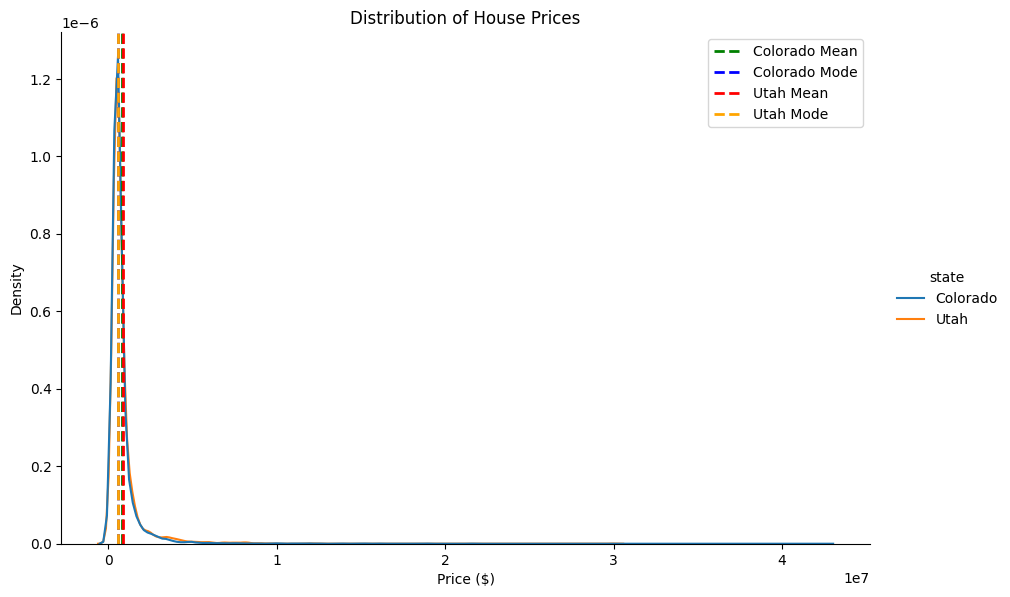

In [7]:
sns.displot(data=df, x='price', hue='state', kind='kde', common_norm=False, height=6, aspect=1.5)
plt.axvline(df[df.state == 'Colorado'].price.mean(), color='green', linestyle='dashed', linewidth=2, label='Colorado Mean')
plt.axvline(df[df.state == 'Colorado'].price.median(), color='blue', linestyle='dashed', linewidth=2, label='Colorado Mode')
plt.axvline(df[df.state == 'Utah'].price.mean(), color='red', linestyle='dashed', linewidth=2, label='Utah Mean')
plt.axvline(df[df.state == 'Utah'].price.median(), color='orange', linestyle='dashed', linewidth=2, label='Utah Mode')
plt.legend()
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')

Text(0.5, 9.444444444444459, 'Price ($)')

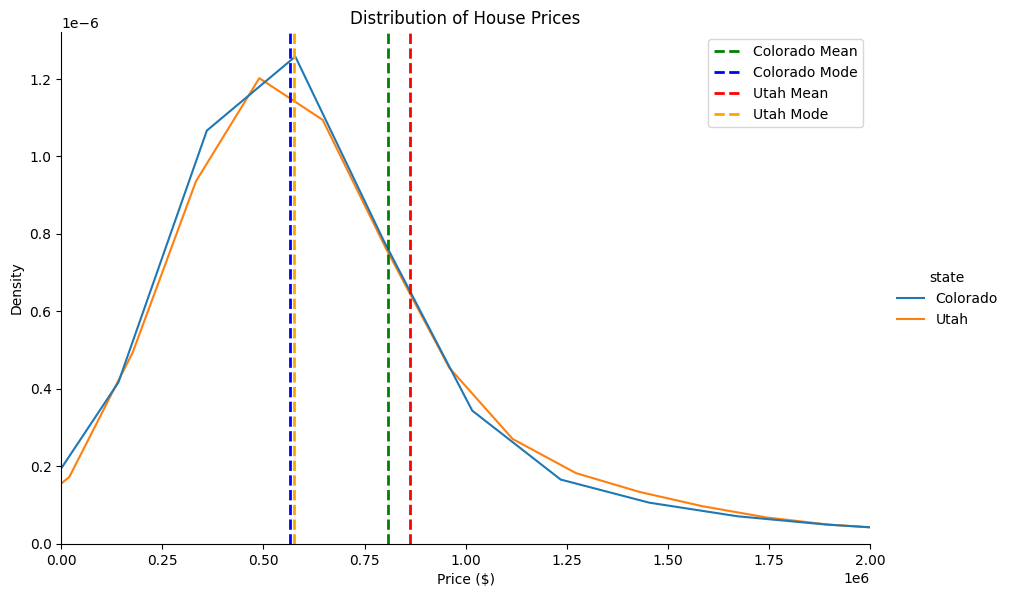

In [8]:
sns.displot(data=df, x='price', hue='state', kind='kde', common_norm=False, height=6, aspect=1.5)
plt.axvline(df[df.state == 'Colorado'].price.mean(), color='green', linestyle='dashed', linewidth=2, label='Colorado Mean')
plt.axvline(df[df.state == 'Colorado'].price.median(), color='blue', linestyle='dashed', linewidth=2, label='Colorado Mode')
plt.axvline(df[df.state == 'Utah'].price.mean(), color='red', linestyle='dashed', linewidth=2, label='Utah Mean')
plt.axvline(df[df.state == 'Utah'].price.median(), color='orange', linestyle='dashed', linewidth=2, label='Utah Mode')
plt.legend()
plt.xlim((0, 2000000))
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')

### Prepare the data for prediction

In [9]:
df['price_range'] = pd.qcut(df['price'], 4)
df['price_range_encoded'] = pd.qcut(df['price'], 4, labels=False)
df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,price_range,price_range_encoded
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09,"(430000.0, 565000.0]",1
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15,"(11999.999, 430000.0]",0
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22,"(11999.999, 430000.0]",0
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04,"(11999.999, 430000.0]",0
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12,"(11999.999, 430000.0]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30,"(11999.999, 430000.0]",0
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23,"(11999.999, 430000.0]",0
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03,"(11999.999, 430000.0]",0
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12,"(430000.0, 565000.0]",1


In [10]:
df['utah'] = df.apply(lambda row: 1 if row.state == 'Utah' else 0, axis=1)
df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,price_range,price_range_encoded,utah
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09,"(430000.0, 565000.0]",1,0
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15,"(11999.999, 430000.0]",0,0
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22,"(11999.999, 430000.0]",0,0
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04,"(11999.999, 430000.0]",0,0
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12,"(11999.999, 430000.0]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30,"(11999.999, 430000.0]",0,1
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23,"(11999.999, 430000.0]",0,1
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03,"(11999.999, 430000.0]",0,1
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12,"(430000.0, 565000.0]",1,1


In [11]:
# df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'])
# df['days_since_last_sale'] = (pd.Timestamp.today() - df['prev_sold_date']).dt.days
# df

## Decision Trees

### Depth of 3

#### Training on whole dataset

In [12]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="gini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="gini = 0.568\nsamples = 2774\nvalue = [1637.0, 750.0, 242.0, 145.0]\nclass = 0", fillcolor="#f4c8a8"] ;
2 -> 4 ;
5 [label="house_size <= 2152.5\ngini = 0.716\nsamples = 8730\nvalue = [1852.0, 3355.0, 2389.0, 1134.0]\nclass = 1", fillcolor="#e3fbe1"] ;
1 -> 5 ;
6 [label="gi

c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.65004513 0.38430699 0.56408426 0.79952969]'

'recall = [0.5947564  0.69146744 0.32396965 0.56761269]'

'f-score = [0.62117292 0.49403622 0.41156551 0.66390041]'

,feature,importance
0,bed,0.000000
1,bath,0.000000
2,acre_lot,0.037471
3,house_size,0.962529
4,utah,0.000000


#### Monte Carlo cross-validation

In [13]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

scores = {'p': [], 'r': [], 'f': []}
for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

    # fit a classification tree on all data
    treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
    treeclf.fit(X_train, y_train)

    y_pred = treeclf.predict(X_test)

    p,r,f,s = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2, 3])
    scores['p'].append(p)
    scores['r'].append(r)
    scores['f'].append(f)

avgP = 0
for pre in scores['p']:
    avgP += pre
avgP /= len(scores['p'])

avgR = 0
for re in scores['r']:
    avgR += re
avgR /= len(scores['r'])

avgF = 0
for f in scores['f']:
    avgF += f
avgF /= len(scores['f'])

display('precision = {}'.format(avgP))
display('recall = {}'.format(avgR))
display('f-score = {}'.format(avgF))

'precision = [0.64712436 0.39213676 0.50238078 0.81320318]'

'recall = [0.59464362 0.56358649 0.45427322 0.54097528]'

'f-score = [0.61968713 0.45073633 0.45131665 0.64920003]'

### Depth of 5

#### Training on whole dataset

In [14]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="acre_lot <= 0.765\ngini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="bath <= 1.5\ngini = 0.377\nsamples = 1495\nvalue = [1157, 213, 87, 38]\nclass = 0", fillcolor="#eca26d"] ;
3 -> 4 ;
5 [label="gini = 0.325\nsamples = 964\nvalue = [779, 139, 35, 11]\nclass = 0", fillcolor="#eb9d65"] ;
4 -> 5 ;
6 [label="gini = 0.462\nsam

c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.61649812 0.41954023 0.56020605 0.76714432]'

'recall = [0.64182494 0.63190437 0.35677671 0.62562604]'

'f-score = [0.62890665 0.50427632 0.43592634 0.6891954 ]'

,feature,importance
0,bed,0.000880
1,bath,0.065093
2,acre_lot,0.082875
3,house_size,0.851152
4,utah,0.000000


#### Monte Carlo cross-validation

In [15]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

scores = {'p': [], 'r': [], 'f': []}
for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

    # fit a classification tree on all data
    treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
    treeclf.fit(X_train, y_train)

    y_pred = treeclf.predict(X_test)

    p,r,f,s = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2, 3])
    scores['p'].append(p)
    scores['r'].append(r)
    scores['f'].append(f)

avgP = 0
for pre in scores['p']:
    avgP += pre
avgP /= len(scores['p'])

avgR = 0
for re in scores['r']:
    avgR += re
avgR /= len(scores['r'])

avgF = 0
for f in scores['f']:
    avgF += f
avgF /= len(scores['f'])

display('precision = {}'.format(avgP))
display('recall = {}'.format(avgR))
display('f-score = {}'.format(avgF))

'precision = [0.61836896 0.42528993 0.51212485 0.76629922]'

'recall = [0.6265635  0.5734154  0.4260614  0.60370882]'

'f-score = [0.62198703 0.48525615 0.45913265 0.67479237]'

### Testing the most important feature only

In [16]:
# create a list of feature columns
feature_cols = ['house_size']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="house_size <= 704.5\ngini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="house_size <= 551.0\ngini = 0.18\nsamples = 165\nvalue = [149, 10, 6, 0]\nclass = 0", fillcolor="#e88e4d"] ;
3 -> 4 ;
5 [label="gini = 0.043\nsamples = 45\nvalue = [44, 0, 1, 0]\nclass = 0", fillcolor="#e6843d"] ;
4 -> 5 ;
6 [label="gini = 0.226\nsampl

c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.61570167 0.40610764 0.4570753  0.83022847]'

'recall = [0.64760528 0.49608409 0.51527578 0.49290484]'

'f-score = [0.63125063 0.44660915 0.48443373 0.6185675 ]'

In [17]:
# create a list of feature columns
feature_cols = ['house_size']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=4, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="house_size <= 704.5\ngini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="gini = 0.18\nsamples = 165\nvalue = [149, 10, 6, 0]\nclass = 0", fillcolor="#e88e4d"] ;
3 -> 4 ;
5 [label="gini = 0.432\nsamples = 1493\nvalue = [1095, 226, 109, 63]\nclass = 0", fillcolor="#eda977"] ;
3 -> 5 ;
6 [label="house_size <= 1450.5\ngini = 0.

c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.65004513 0.40121581 0.45302365 0.75293788]'

'recall = [0.5947564  0.54410552 0.44392044 0.56156093]'

'f-score = [0.62117292 0.46186144 0.44842585 0.64331819]'

## Neural Networks